# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

## Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


##### **Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [ ]:
# Проверим пропущенные значения в таблице признаков X, с помощью функции isna()
# которая говорит для каждого значения является ли оно неопределенным,
# isna().sum() - возвращает статистику по столбцам, соответственно еще раз их
# просуммируем и получим количество пропусков в нашей таблице признаков.
# (Нам повезло, их не оказалось)
print(f"Пропущенные значения в признаках: {X.isna().sum().sum()}")
# Что-то похожее сделаем для y, однако это не DataFrame, а массив значений,
# поэтому используем функцию np.isnan() и опять же возьмем сумму, в результате
# получим количество пропущенных значений.
# (Нам опять повезло, их снова не оказалось)
print(f"Пропущенные значения в target: {np.isnan(y).sum()}")

# Выводим типы данных по столбцам для таблицы признаков, все значения оказались
# числовыми => категориальных переменных нет.
print(f"\nТипы данных столбцов таблицы признаков:\n{X.dtypes}")
# Выводим тип данных targetа: тут тоже числовое значение, а значит это не
# категориальная переменная
print(f"\nТип данных столбца таргетов:\n{y.dtype}")

Пропущенные значения в признаках: 0
Пропущенные значения в target: 0

Типы данных столбцов таблицы признаков:
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

Тип данных столбца таргетов:
int64


##### **Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [ ]:
from sklearn.model_selection import train_test_split

# Фиксируем random seed, можно было бы зафиксировать его и в функции
# train_test_split параметром random_state, но идем по заданию.
np.random.seed(99)

# Делим наши данные на 2 выборки - train and test, выставляем долю тестовой
# выборки в 0.3, и делаем stratify по y, чтобы соотношение классов в y_train,
# y_test было примерно как в изначальном y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

##### **Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
# Для начала отмасштабируем признаки: обучаем Scaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)
# Затем, приводим все признаки (и из обучающей, и из тестовой выборки) к тому
# же масштабу
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

In [ ]:
knn_classifiers = []

print("NN 	 Train 	 Test")
for neighbors in [1, 3, 5, 10, 15, 25]:

  # Создаем классификатор kNN для текущего числа соседей
  knn = KNeighborsClassifier(n_neighbors=neighbors, p=2)

  # Обучаем нашу модель на двух признаках обучающей выборки по заданию
  knn.fit(X_train[['alcohol', 'magnesium']], y_train)
  # Сохраним обученный классификатор для следующего задания
  knn_classifiers.append(knn)

  # Получаем предикты для обоих наборов, опять же только по двум признакам
  y_train_predicted = knn.predict(X_train[['alcohol', 'magnesium']])
  y_test_predicted = knn.predict(X_test[['alcohol', 'magnesium']])

  # Считаем процент правильных предсказаний
  accuracy_train = accuracy_score(y_train, y_train_predicted)
  accuracy_test = accuracy_score(y_test, y_test_predicted)
  # Выводим полученные результаты: как можно заметить, наиболее хорошим оказался
  # классификатор с числом соседей 3 (На тестовой самый большой процент
  # попаданий 78% + на обучающей 81%)
  print(f'{neighbors:<9}{accuracy_train:<8.2f}{accuracy_test:.2f}')

NN 	 Train 	 Test
1        1.00    0.61
3        0.81    0.78
5        0.79    0.74
10       0.75    0.70
15       0.72    0.70
25       0.73    0.72


Самый лучший результат для тестовой выборки показывает kNN для трех соседей. При этом и на обучающей выборке все хорошо.

##### **Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [ ]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [ ]:
import mlxtend

##### **Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

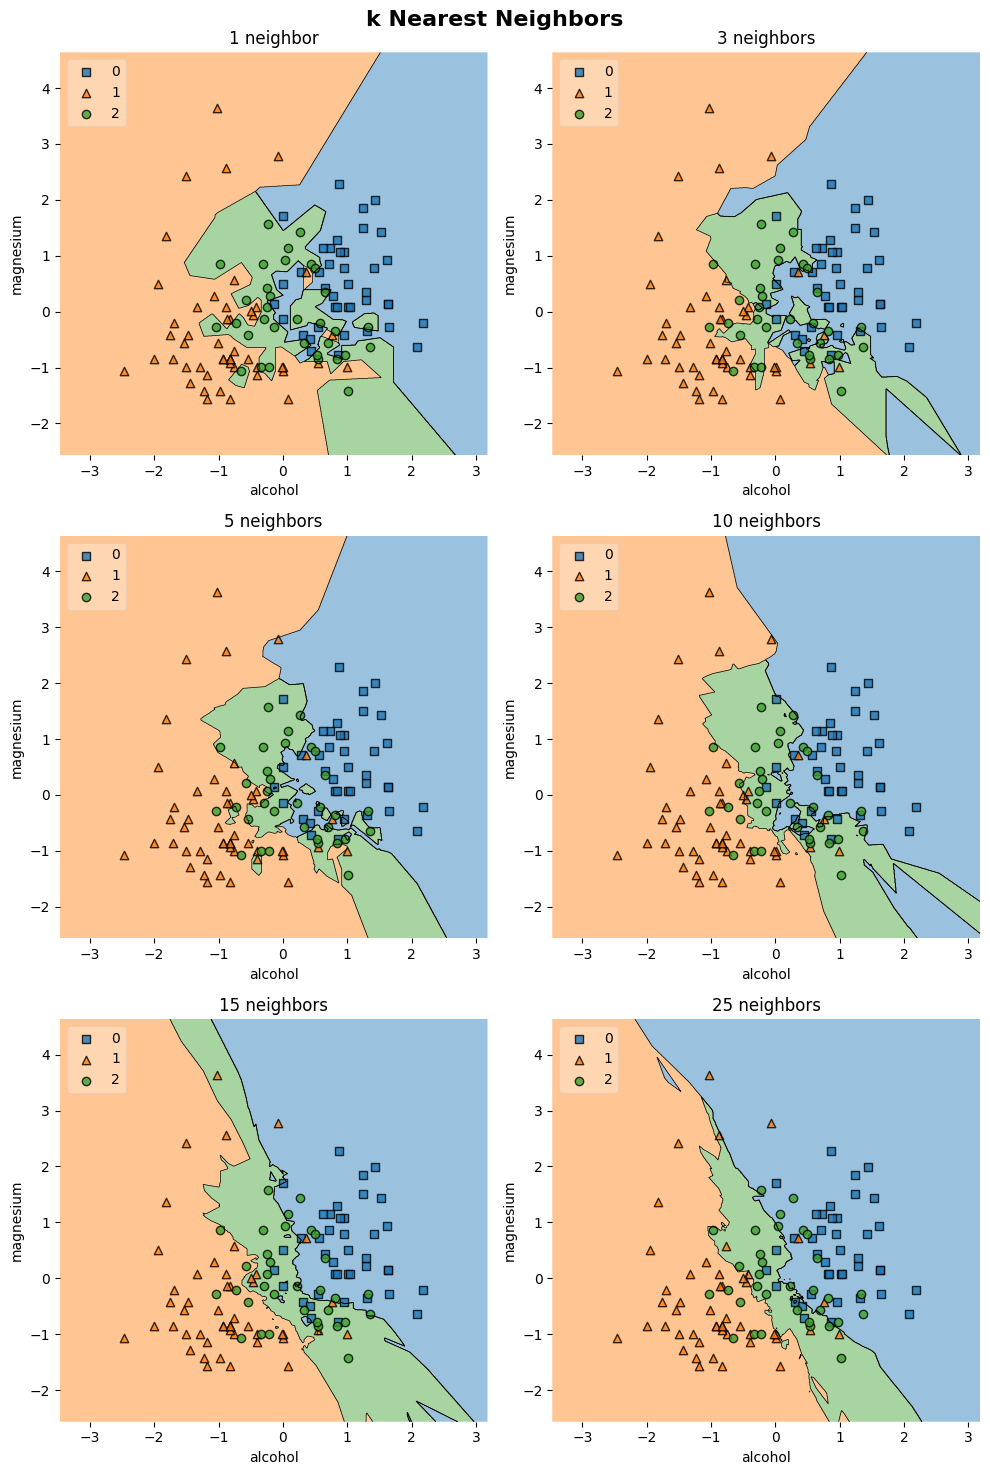

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
# Задаем сетку графиков
gs = gridspec.GridSpec(3, 2)

# А также размер
fig = plt.figure(figsize=(10,15))
# Даем общее название нашему графику
fig.suptitle("k Nearest Neighbors", size=16, fontweight="bold")

# И подписываем каждый график
labels = ['1 neighbor', '3 neighbors', '5 neighbors',
          '10 neighbors', '15 neighbors', '25 neighbors']
# Графики будем строить в цикле
for model, label, grd in zip(knn_classifiers, labels,
                             [[0,0], [0,1],[1,0], [1,1], [2,0], [2,1]]):
    # Строим график
    ax = plt.subplot(gs[grd[0], grd[1]])
    # Мы рассматриваем только два признака, явно выделяем их и берем текущую,
    # заранее обученную модель (в прошлом задании).
    fig = plot_decision_regions(X=X_train[['alcohol', 'magnesium']].to_numpy(),
                                y=y_train, clf=model, legend=2)
    # Подписываем оси
    fig.set_xlabel('alcohol')
    fig.set_ylabel('magnesium')
    # И даем название из заранее созданного массива названий
    plt.title(label)

# Делаем tight_layout для того чтобы графики не налегали друг на друга
plt.tight_layout()
plt.show()

##### **Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

1. Результаты задания 1.3: <br/>
```
NN 	  Train   Test
1        1.00    0.61
3        0.81    0.78
5        0.79    0.74
10       0.75    0.70
15       0.72    0.70
25       0.73    0.72
```

  Как можно заметить, лучший результат на тестовой выборке показал kNN для **трех** соседей, при этом результат на обучающей выборке так же самый высокий (мы не считаем 1.00 при 1 соседе, так как это просто из-за того, что мы обучали на тех же данных и каждая точка попала в саму себя).

2. Из графиков задания 1.5 можно заметить, что для трех соседей результаты весьма хороши, единственное что немного некрасиво - центр графика, где синие и зеленые точки лежат близко и получается немного не равномерная закраска хотя и вырисовываются регионы с точками одного цвета (это объясняется наличием точек обеих цветов), но надо отметить что здесь она гораздо лучше, чем при других k.

**Поэтому, я считаю, что оптимальный выбор: k = 3.**

Говоря о переобучении:
- можно выделить в задании 1.3 результаты для k = 1, как можно понять, модель слишком сильно подогналась под обучающую выборку (100% попаданий), а на тестовой показывает самые плохие результаты;
- в графиках для k = 10, 15, 25 также видно, что в областях, которые должны быть одного цвета есть совсем маленькие вкрапления другого цвета, хотя точек этого класса рядом нет => модель переобучилась.


## Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

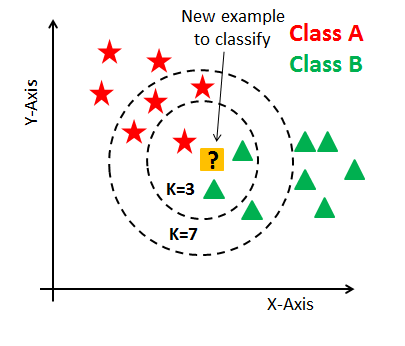

In [ ]:
import numpy as np
from collections import Counter
from math import sqrt

class KNN:
    def __init__(self, k:int):
      # инциализируем количество ближайших соседей
      self.k = k

    def fit(self, X, y):
      # Во время обучения просто запоминаем обучающую выборку и таргеты для нее
      self.X = X
      self.y = y
      pass

    def predict(self, X):

      # функцию predict максимально оптимизируем (уберем все циклы), это
      # требовали в самом начале этого .ipynb файла

      # эта функция будет применена к каждому элементу в массиве Х, то есть она
      # делает предикт для одного объекта
      def find_class(x):
          # это массив всех элементов в формате (дистанция, класс)
          # используем np.apply_along_axis для того чтобы это сработало для
          # каждого элемента и прицепляем, с помощью zip к нему значение его класса
          nearest_classes = np.array(list(zip(np.apply_along_axis(lambda our_object: self.count_distance(our_object, x), 1, self.X), self.y)))

          # Первым в паре была дистанция, соответственно, если отсортировать, то
          # массив отсортируется по удаленности от объекта, для которого мы делаем
          # предикт. То есть, тут мы просто сортируем массив по первому значению из пары
          nearest_classes = nearest_classes[np.argsort(nearest_classes[:,0])]
          # берем К ближайших
          nearest_classes = nearest_classes[:self.k]
          # Сортируем по количеству одинаковых элементов в массиве (по убыванию)
          result = Counter(dict(nearest_classes)).most_common()
          # и записываем в результат класс самого часто встречающегося
          return result[0][1]

      # Создаем массив предиктов, применив функцию ко всем элементам из Х
      results = np.apply_along_axis(find_class, 1, X)

      return results
      pass

    def count_distance(self, x, y):
      # Считаем евклидово расстояние между точками (сделал не просто формулу
      # sqrt(x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2), а c применением функции,
      # чтобы если мы перешли из плоскости в трехмерное пространство, например,
      # то все равно работало)

      # считаем в массив значения x[i] - y[i]
      x = np.subtract(x, y)
      # считаем квадраты значений
      x = np.apply_along_axis(lambda x: x ** 2, 0, x)
      # берем корень из суммы
      return sqrt(x.sum())
      pass

In [ ]:
# Не меняйте файл!
def test_knn(KNN):

  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [ ]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

## Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [ ]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw04_knn_linreg/diamonds.csv

--2024-03-21 10:17:12--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw04_knn_linreg/diamonds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3192560 (3.0M) [text/plain]
Saving to: ‘diamonds.csv’

diamonds.csv        100%[===================>]   3.04M  --.-KB/s    in 0.07s   

2024-03-21 10:17:12 (44.8 MB/s) - ‘diamonds.csv’ saved [3192560/3192560]



In [ ]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

##### **Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [ ]:
# Удалим столбец не несущий полезной информации
data.drop(['Unnamed: 0'], axis=1, inplace=True)

# Проверим пропущенные значения в таблице, с помощью функции isna()
# которая говорит для каждого значения является ли оно неопределенным,
# isna().sum() - возвращает статистику по столбцам, соответственно еще раз их
# просуммируем и получим количество пропусков в нашей таблице признаков.
# (Нам повезло, их не оказалось)
print(f"Пропущенные значения: {data.isna().sum().sum()}")

Пропущенные значения: 0


##### **Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [ ]:
# Посчитаем корреляцию всех вещественных признаков со всеми и выведем только
# столбец price, что требуется по условию
pd.DataFrame(data.corr()['price'])

,price
carat,0.921591
depth,-0.010647
table,0.127134
price,1.000000
x,0.884435
y,0.865421
z,0.861249


Как можно заметить цена очень сильно коррелирует с признаками price (как ни странно, сама с собой 😃), carat (тоже понятно, чем больше карат, тем больше цена), X, Y и Z (опять же, чем больше длина, ширина или высота, тем больше бриллиант и выше цена).

Остальные признаки практически не коррелируют с ценой.

##### **Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [ ]:
# Закодируем категориальные признаки с помощью get_dummies()
data = pd.get_dummies(data)
data.sample(5)

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
24124,2.36,58.9,64.0,12286,8.75,8.68,5.14,0,1,0,...,0,1,0,0,0,1,0,0,0,0
11497,1.12,61.5,57.0,5018,6.74,6.68,4.13,0,0,1,...,0,0,0,0,0,1,0,0,0,0
24603,1.75,63.8,57.0,12918,7.63,7.53,4.84,0,1,0,...,0,0,0,0,1,0,0,0,0,0
28227,0.33,60.5,58.0,666,4.43,4.49,2.70,0,0,0,...,0,0,0,0,0,0,1,0,0,0
16635,0.91,62.3,59.0,6652,6.16,6.19,3.85,0,0,1,...,0,0,0,0,0,0,1,0,0,0


##### **Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [ ]:
# Для начала выделим наш таргет и уберем его из таблицы признаков
y = data['price']
data.drop('price', axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

# Фиксируем random seed
np.random.seed(12)

# Делим наши данные на 2 выборки - train and test, выставляем долю тестовой
# выборки в 0.3
# Stratify по таргету мы делать не можем, из-за того что это задача регрессии и
# target - вещественное число. Однако, нам все равно важно хорошее распределение
# данных, поэтому мы сделаем stratify по столбцам данных. Опять же мы не можем
# сделать это по вещественным признакам, однако мы как раз до этого сделали One-
# hot encoding => получилис столбцы в к-рых только 0 и 1. Делаем stratify по
# всем столбцам, относящимся к cut и color.
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=data[['cut_Fair', 'cut_Good',
       'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J']])

##### **Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Обучаем Scaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train[['carat', 'depth', 'table', 'x', 'y', 'z']])
# Затем, приводим вещественные признаки (и из обучающей, и из тестовой выборки)
# к тому же масштабу, явно изменяя столбцы на отмасштабированные
X_train[['carat', 'depth', 'table', 'x', 'y', 'z']] = scaler.transform(X_train[['carat', 'depth', 'table', 'x', 'y', 'z']])
X_test[['carat', 'depth', 'table', 'x', 'y', 'z']] = scaler.transform(X_test[['carat', 'depth', 'table', 'x', 'y', 'z']])

##### **Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Создаем модель линейной регрессии
model = LinearRegression()
# Обучаем ее на обучающей выборке
model.fit(X_train, y_train)

# Делаем предикт для обучющей выборки
y_train_predicted = model.predict(X_train)
# и для тестовой выборки
y_test_predicted = model.predict(X_test)

# Считаем среднквадратичную ошибку на обеих выборках.
print(f"MSE на обучающей выборке {mean_squared_error(y_train, y_train_predicted):.2f}")
print(f"MSE на тестовой выборке {mean_squared_error(y_test, y_test_predicted):.2f}")

MSE на обучающей выборке 1294622.54
MSE на тестовой выборке 1238140.36


##### **Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [ ]:
# Выведем коэффициенты для каждого признака
coefficents = pd.DataFrame(zip(X_train.columns, model.coef_), columns=['Feature', 'Coefficient'])
coefficents

,Feature,Coefficient
0,carat,5297.118764
1,depth,-90.220323
2,table,-65.775472
3,x,-1196.127300
4,y,130.854291
5,z,-31.438190
6,cut_Fair,-528.405017
7,cut_Good,-19.332061
8,cut_Ideal,243.052687
9,cut_Premium,175.717097


**Можно заметить, что коэффициенты вещественных признаков carat и x, clarity_I1, clarity_IF на порядок больше остальных.** (А значит и их вклад больше, чем у остальных. + они влияют на цену больше чем остальные).

##### **Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# Создаем модель с Lasso-регрессией
model_lasso = Lasso(alpha=10)
# обучаем ее
model_lasso.fit(X_train, y_train)

# Создаем модель с Ridge-регрессией
model_ridge = Ridge(alpha=10)
# обучаем ее
model_ridge.fit(X_train, y_train)

# Выводим коэффициенты в табличке
pd.DataFrame(data=zip(X_train.columns, model.coef_, model_lasso.coef_, model_ridge.coef_),
             columns=['Feature', 'LinearRegeression', 'Lasso', 'Ridge'])

,Feature,LinearRegeression,Lasso,Ridge
0,carat,5297.118764,4815.312962,5257.287888
1,depth,-90.220323,-99.583160,-88.701686
2,table,-65.775472,-83.857167,-66.098732
3,x,-1196.127300,-661.348639,-1141.209943
4,y,130.854291,-0.000000,115.369273
5,z,-31.438190,-27.060938,-34.704875
6,cut_Fair,-528.405017,-377.035187,-531.909029
7,cut_Good,-19.332061,-37.644480,-18.803293
8,cut_Ideal,243.052687,90.609143,244.312728
9,cut_Premium,175.717097,0.000000,175.520834


Мы видим, что Lasso уменьшил по модулю многие коэффициенты, а некоторые даже занулил, а значит значение этого признака игнорируется и его можно убрать из модели. Явно выделяются признаки Х, clarity_VVS1, clarity_VVS2 - уменьшение коэффициентов в 2 раза.

Зануление признаков, а также серьезное уменьшение коэффициентов и есть показатель мультиколлинеарности.

Также видно, что Ridge также уменьшил по модулю многие коэффициенты, но не сильно (кроме признака Х - здесь опять же заметное уменьшение).

То есть, явно видно, что проблема мультиколлинеарности была довольно серьезной в изначальной регрессии.

##### **Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [ ]:
# запомним в массивы получившиеся евклидовы нормы весов для каждой альфы
lasso_norms = []
ridge_norms = []
alphas = [0.1, 1, 10, 100, 200]

# Пройдем по каждой альфе
for alpha in alphas:
  # Создаем модель с Lasso-регрессией
  model_lasso = Lasso(alpha=alpha)
  # обучаем ее
  model_lasso.fit(X_train, y_train)
  # Запоминаем евклидову норму
  lasso_norms.append(np.linalg.norm(model_lasso.coef_))

  # Создаем модель с Ridge-регрессией
  model_ridge = Ridge(alpha=alpha)
  # обучаем ее
  model_ridge.fit(X_train, y_train)
  # Запоминаем евклидову норму
  ridge_norms.append(np.linalg.norm(model_ridge.coef_))

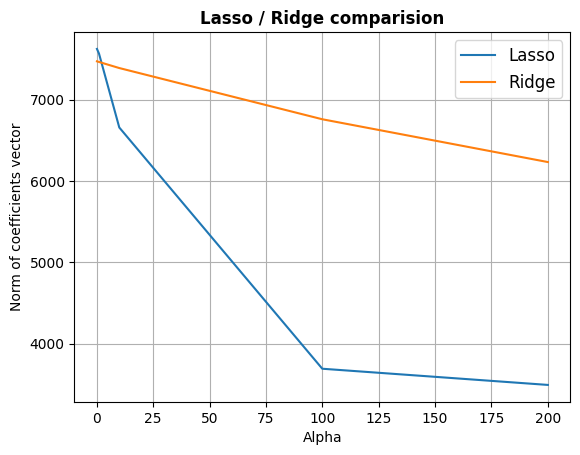

In [ ]:
# Построим два графика
plt.title('Lasso / Ridge comparision', fontweight='bold')

# по Ох будут значения альфа, а по Оу - значения евклидовых норм
plt.plot(alphas, lasso_norms)
plt.plot(alphas, ridge_norms)

plt.xlabel('Alpha')
plt.ylabel('Norm of coefficients vector')
plt.grid(visible=True)

plt.legend(['Lasso', 'Ridge'], fontsize='large')

plt.show()

**Явно видно, что Lasso агрессивнее уменьшает веса.**

Поэтому этот метод и используют для отбора признаков - признаки с маленькими весами быстро теряют свой вес и даже зануляются, в то время как более важные признаки начинают выделяться своим весом.

##### **Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [ ]:
from sklearn.linear_model import LassoCV

# Создаем модель LassoCV со значениями альфа из предыдущих заданий и
# количеством блоков = 5
model_lasso_cv = LassoCV(alphas=alphas, cv=5)
# Обучим модель
model_lasso_cv.fit(X_train, y_train)

# Сначала сделаем таблицу по всем значениям MSE для каждого блока
alphas_table = pd.DataFrame(model_lasso_cv.mse_path_, index=model_lasso_cv.alphas_)
# Затем посчитаем среднее значение MSE для каждой альфы и выведем ответ
alphas_table_mean = pd.DataFrame(alphas_table.mean(axis=1), columns=['mean MSE by CV'])
alphas_table_mean

,mean MSE by CV
200.0,2.458002e+06
100.0,2.251713e+06
10.0,1.334650e+06
1.0,1.298465e+06
0.1,1.310511e+06


**Соответственно, минимальная средняя MSE получается при alpha = 1 => при таком альфа у нас самое лучшее качество.**

##### **Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [ ]:
# Создаем модель с Lasso-регрессией
model_lasso = Lasso(alpha=1)
# обучаем ее
model_lasso.fit(X_train, y_train)

# Выводим коэффициенты в табличке
pd.DataFrame(data=zip(X_train.columns, model_lasso.coef_),
             columns=['Feature', 'Coefficient'])

,Feature,Coefficient
0,carat,5250.062609
1,depth,-92.281533
2,table,-67.826428
3,x,-1048.486936
4,y,17.689257
5,z,-26.385020
6,cut_Fair,-636.982024
7,cut_Good,-139.485547
8,cut_Ideal,108.711133
9,cut_Premium,34.476640


Как мы уже знаем, Lasso зануляет неинформативные признаки, у нас так и получилось:

Неинформативными оказались cut_Premium, color_G. Это понятно, так как мы использовали One-hot encoding и раскладывали признаки cut, color по всем возможным состояниям, то если убрать одно из них, то его все равно можно будет определить через другие. Тут также заметно явное уменьшение по модулю (значение стало ближе к нулю) у clarity_VS2, опять же из-за One-hot encoding.

А самыми информативными все еще остались:
- carat - чем больше бриллиант тем выше цена;
- X - Чем длинее бриллианты, тем реже их используют (если другие два измерения маленькие);
- cut_Fair - это самый плохой разрез, при нем цена меньше;
- color_J - это самый плохой цвет, и цена уменьшается при нем;
- clarity_I1 - это самое плохое качество, а значит цена уменьшается при этом качестве;
- clarity_SI2 - а это второе самое плохое качество, цена тоже уменьшается при этом качестве.

##### **Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [ ]:
y_test_predicted_lasso = model_lasso.predict(X_test)
print(f"MSE для Lasso: {mean_squared_error(y_test, y_test_predicted_lasso):.2f}")
y_test_predicted = model.predict(X_test)
print(f"MSE для обычной линейной регрессии: {mean_squared_error(y_test, y_test_predicted):.2f}")

MSE для Lasso: 1236697.35
MSE для обычной линейной регрессии: 1238140.36


Как мы видим, нам удалось решить проблему мультиколлинеарности и улучшить результаты на 0,116%. Сделали мы это с помощью L1 регуляризации. Соответственно лучше использовать модель, обученную Lasso-регрессии. Потому что, она справляется с мультиколлинеарностью признаков, в то время как обычная линейная регрессия не может этого сделать.

### Спасибо! И хорошего дня!